In [1]:
import pandas as pd
import re
import os
from functools import reduce
import numpy as np
from scipy.stats import norm

In [2]:
def get_meta_stats_helper(ser, ancestry, alpha=0.05):
    effect_sizes = np.array([ser[f"bmi_rint_coef_{a}"] for a in ancestry if not pd.isnull(ser[f"bmi_rint_coef_{a}"])])
    inverse_variances = np.array([(1/ser[f"bmi_rint_se_{a}"]**2) for a in ancestry if not pd.isnull(ser[f"bmi_rint_se_{a}"])])
    assert len(effect_sizes)==len(inverse_variances)

    if len(effect_sizes)==0:
        return pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA, pd.NA

    weighted_effect_size = np.sum(effect_sizes*inverse_variances)/np.sum(inverse_variances)
    weighted_variance = 1/np.sum(inverse_variances)
    weighted_se = np.sqrt(weighted_variance)

    # Calculate the Z-score
    z_score = weighted_effect_size / weighted_se
    # Calculate the two-tailed p-value
    p_value = 2 * norm.sf(abs(z_score)) #(1 - norm.cdf(abs(z_score)))

    # Calculate critical value for confidence interval
    z_critical = norm.ppf(1 - alpha / 2) 

    # Calculate confidence interval bounds
    lower_ci = weighted_effect_size - z_critical * weighted_se
    upper_ci = weighted_effect_size + z_critical * weighted_se

    nobs = sum([ser[f"bmi_rint_obs_{a}"] for a in ancestry if not  pd.isnull(ser[f"bmi_rint_obs_{a}"])])
    return weighted_effect_size, weighted_se, lower_ci, upper_ci, z_score, p_value, nobs

def get_meta_stats(ser):
    biobank = ["aou", "ukb"]
    es, se, lci, hci, z_score, p_value, nsamples = get_meta_stats_helper(ser, biobank)
    return pd.Series(
        {"gene": ser.gene, "gene_mask": ser.gene_mask, 
        "beta": es, "se": se, "ci_low": lci, "ci_high": hci, "z_score":z_score, "p_value": p_value, "nobs": nsamples
        })

def get_most_deleterious_idx(ser):
    all_masks = set(ser.unique())
    most_del = "Missense_lenient"
    if "pLoF" in all_masks:
        most_del = "pLoF"
    elif "Missense_strict" in all_masks:
        most_del = "Missense_strict"
    most_del_idx = ser.loc[ser==most_del].index[0]
    return most_del_idx




In [3]:
PROJECT_DIR = "/Users/deeprobanerjee/Documents/bmi_project/BMI_monogenic"

ukb_df = pd.read_csv(os.path.join(PROJECT_DIR, "data/pgs_interaction/monogenic_pgs_int_ukb_eur.csv.gz"))
aou_df = pd.read_csv(os.path.join(PROJECT_DIR, "data/pgs_interaction/monogenic_pgs_int_aou_eur.csv.gz"))

meta_df = aou_df.merge(
    ukb_df, 
    on=["gene", "gene_mask"], 
    suffixes=("_aou", "_ukb")
    )


In [4]:
meta_res_df = meta_df.apply(get_meta_stats, axis=1)

In [6]:
filename = os.path.join(PROJECT_DIR, "data/meta/tables/monogenic_meta_most_deleterious.tsv")
most_del_sig_meta_df = pd.read_csv(filename, sep="\t")

most_del_sig_meta_res_df = meta_res_df.merge(most_del_sig_meta_df.loc[:, ["gene", "gene_mask"]], on=["gene", "gene_mask"])
most_del_sig_meta_res_df.to_excel(os.path.join(PROJECT_DIR, "data/pgs_interaction/meta_pgs_interaction.xlsx"), index=False)


# Forest plot

In [7]:
import os
import re
import pandas as pd
import numpy as np
import requests
import time
import json

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages


In [23]:
def create_forestplot(
    df, studies,
    labels_col, effect_sizes_col, ci_low_col, ci_high_col,
    stats_cols
):

    # Create a figure with two axes
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(3.5, 4), gridspec_kw={'width_ratios': [1.5, 2]},sharey=True)

    # Horizontal line at 0 for the null effect
    ax.axvline(x=0, color='k', linestyle='--')
    
    df["ci_low_error"] = df[effect_sizes_col] - df[ci_low_col]
    df["ci_high_error"] =  df[ci_high_col] - df[effect_sizes_col]
    
    ### main plot ###
    # Plotting the effect sizes with different markers per category
    last_offset = 0
    for i, study in enumerate(studies):
        effect_size = df.loc[(df[labels_col]==study), effect_sizes_col].values[0]
        ci_low_error = df.loc[(df[labels_col]==study), "ci_low_error"].values[0]
        ci_high_error = df.loc[(df[labels_col]==study), "ci_high_error"].values[0]
        errors = np.array([ci_low_error, ci_high_error]).reshape(2, 1)
        # Plot each category with a different marker
        ax.errorbar(effect_size, i+last_offset*0.25, xerr=[[ci_low_error], [ci_high_error]], fmt="o", color="k", capsize=2.5)

        # Place the study name above the group of categories
        ax.text(min(df[ci_low_col])-0.2, i+last_offset, study, ha='center', va='center', fontweight='normal', style="italic")

        
    ax.text(min(df[ci_low_col])-0.2, -1, "Genes", ha='center', va='center', fontweight='normal')
    
    # Invert the y-axis so the studies are from top to bottom
    ax.invert_yaxis()

    # Customize the left axis: remove yticks but keep the ytick labels for study names
    ax.set_yticks([])
    ax.tick_params(axis='y', which='both', length=0) 


    # Labels for axes
    ax.set_xlabel('Effect Size')
    # ax.set_title('Forest Plot')
    # Remove top, right, and left spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    last_offset = 0

    for i, study in enumerate(studies):
        for s, st_col in enumerate(stats_cols):
            stat = df.loc[(df[labels_col]==study), st_col].values[0]
            ax2.text(0.1+0.5*s,i+last_offset*0.25, f"{stat}", va='center', ha="center")
            if i==0:
                if s<2:
                    ax2.text(0.1+0.5*s, -1, f"{st_col.lstrip('formatted_')}", va='center', ha="center")

    # Remove the spines and ticks for ax2
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    # ax2.set_title('Statistics')

    plt.tight_layout()
    return fig


In [24]:
def p_value_formatter(pval):
    if pval==0:
        pval = "0"
    else:
        pval = f"{pval:.2e}"
        pval = pval.replace("e", "x10")
        # base, exponent = pval.split("^")
        # pval = f"{base}$^{{{exponent}}}$"
        # #pval = f"{base}$^{exponent}$"
    return pval

most_del_sig_meta_res_df["formatted_beta"] = most_del_sig_meta_res_df.beta.apply(lambda x: f"{x:.2f}")
most_del_sig_meta_res_df["formatted_ci"] = "(" + most_del_sig_meta_res_df.ci_low.apply(lambda x: f"{x:.2f}") + ", " + most_del_sig_meta_res_df.ci_high.apply(lambda x: f"{x:.2f}") + ")"
most_del_sig_meta_res_df["formatted_se"] = most_del_sig_meta_res_df.se.apply(lambda x: f"{x:.2f}")
most_del_sig_meta_res_df["formatted_z_score"] = most_del_sig_meta_res_df.z_score.apply(lambda x: f"{x:.2f}")
most_del_sig_meta_res_df["formatted_p_value"] = most_del_sig_meta_res_df.p_value.apply(p_value_formatter)
most_del_sig_meta_res_df["Beta (95% CI)"] = most_del_sig_meta_res_df.apply(lambda ser: f"{ser.formatted_beta} {ser.formatted_ci}", axis=1)

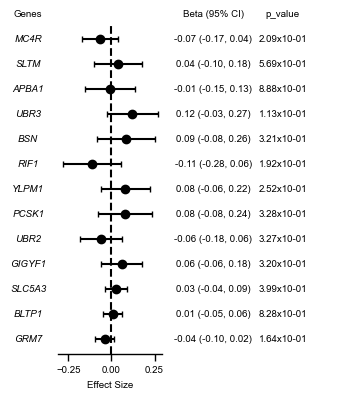

In [25]:
f = create_forestplot(most_del_sig_meta_res_df, most_del_sig_meta_df.gene.unique(),
    labels_col="gene", effect_sizes_col="beta", ci_low_col="ci_low", ci_high_col="ci_high",
    stats_cols=["Beta (95% CI)", "formatted_p_value"]
)

In [26]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [27]:
save_pdf(os.path.join(PROJECT_DIR, "data/pgs_interaction/pgs_interaction.pdf"), f)

# Supplementary Table

In [5]:
PROJECT_DIR = "/Users/deeprobanerjee/Documents/bmi_project/BMI_monogenic"

In [6]:
import pandas as pd
import os

In [9]:
aou_df = pd.read_csv(os.path.join(PROJECT_DIR, "data/pgs_interaction/pgs_int_examples_aou.csv"), index_col=0)
ukb_df = pd.read_csv(os.path.join(PROJECT_DIR, "data/pgs_interaction/pgs_int_examples_ukb.csv"), index_col=0)

In [20]:
aou_df["biobank"] = "aou"
ukb_df["biobank"] = "ukb"
pgs_cat_df = pd.concat([aou_df, ukb_df])
pgs_cat_df["prs_cat"] = pgs_cat_df.prs_cat + 1
stats_cols = ["mean_bmi_carrier", "mean_bmi_noncarrier", "ncarrier", "nnoncarrier", "t_stat", "p_value"]
pgs_cat_df = pgs_cat_df.pivot(columns="biobank", index="prs_cat", values=stats_cols)
pgs_cat_df.columns = pd.MultiIndex.from_tuples(
        [(g, stat) for stat, g in pgs_cat_df.columns],
        names=["Biobank", "Statistic"]
    )

In [22]:
pgs_cat_df.loc[:, [(b, s) for b in ["ukb", "aou"] for s in stats_cols]].to_excel(os.path.join(PROJECT_DIR, "data/pgs_interaction/bmi_by_pgs_cat.xlsx"))
